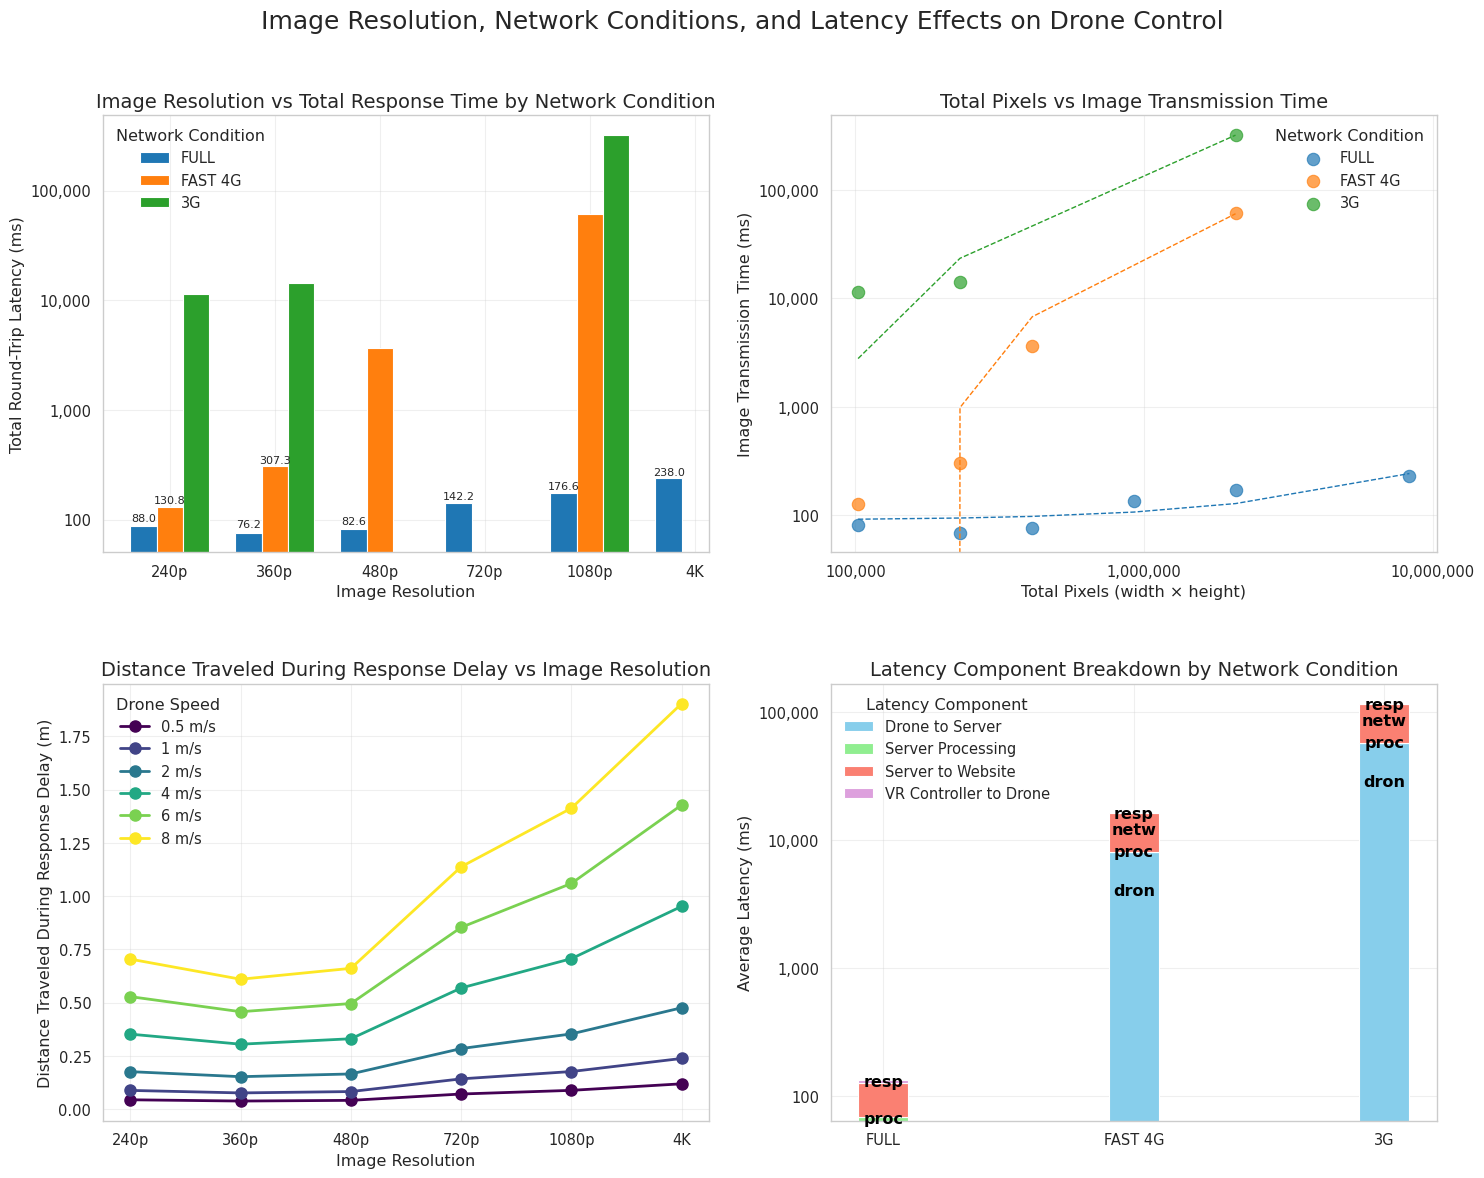

Detailed Results Table by Network Condition:


FULL NETWORK CONDITION


,resolution,size,Image Transmission (ms),Total Round-Trip Latency (ms),Distance at 0.5 m/s (m),Distance at 1 m/s (m),Distance at 2 m/s (m),Distance at 4 m/s (m),Distance at 6 m/s (m),Distance at 8 m/s (m)
4,240p,426x240,81.1,88.036,0.044018,0.088036,0.176072,0.352144,0.528216,0.704288
1,360p,640x360,69.3,76.236,0.038118,0.076236,0.152472,0.304944,0.457416,0.609888
3,480p,854x480,75.7,82.636,0.041318,0.082636,0.165272,0.330544,0.495816,0.661088
0,720p,1280x720,135.3,142.236,0.071118,0.142236,0.284472,0.568944,0.853416,1.137888
5,1080p,1920x1080,169.7,176.636,0.088318,0.176636,0.353272,0.706544,1.059816,1.413088
2,4K,3840x2160,231.1,238.036,0.119018,0.238036,0.476072,0.952144,1.428216,1.904288



FAST_4G NETWORK CONDITION


,resolution,size,Image Transmission (ms),Total Round-Trip Latency (ms),Distance at 0.5 m/s (m),Distance at 1 m/s (m),Distance at 2 m/s (m),Distance at 4 m/s (m),Distance at 6 m/s (m),Distance at 8 m/s (m)
1,240p,426x240,126.6,130.77504,0.065388,0.130775,0.26155,0.5231,0.78465,1.0462
2,360p,640x360,303.1,307.27504,0.153638,0.307275,0.61455,1.2291,1.84365,2.4582
3,480p,854x480,3650.1,3654.27504,1.827138,3.654275,7.30855,14.6171,21.92565,29.2342
0,1080p,1920x1080,60924.9,60929.07504,30.464538,60.929075,121.85815,243.7163,365.57445,487.4326



3G NETWORK CONDITION


,resolution,size,Image Transmission (ms),Total Round-Trip Latency (ms),Distance at 0.5 m/s (m),Distance at 1 m/s (m),Distance at 2 m/s (m),Distance at 4 m/s (m),Distance at 6 m/s (m),Distance at 8 m/s (m)
1,240p,426x240,11340.4,11350.788096,5.675394,11.350788,22.701576,45.403152,68.104729,90.806305
2,360p,640x360,14291.6,14301.988096,7.150994,14.301988,28.603976,57.207952,85.811929,114.415905
0,1080p,1920x1080,320993.2,321003.588096,160.501794,321.003588,642.007176,1284.014352,1926.021529,2568.028705


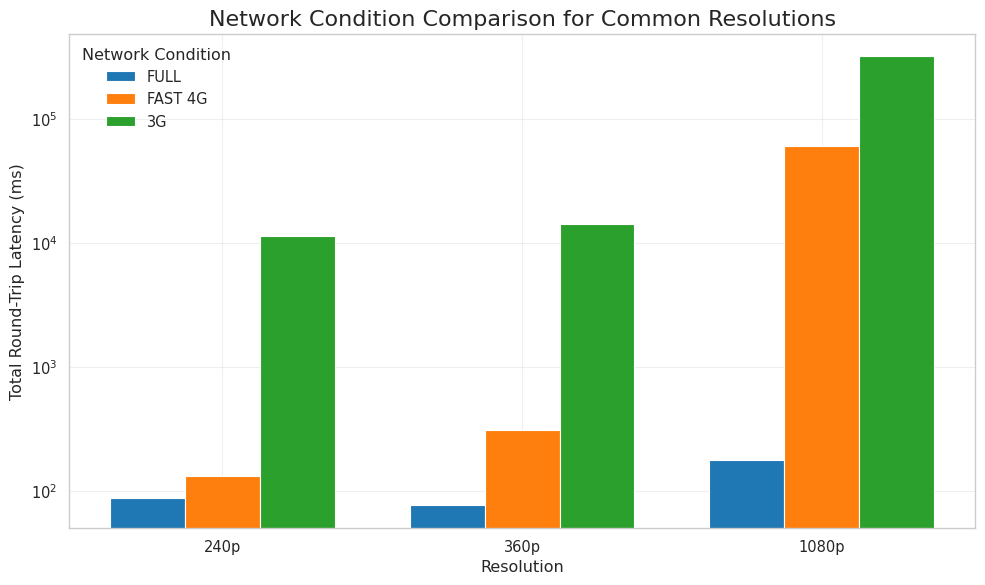

In [9]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker

# Set the visual style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'DejaVu Sans'

# Load the data
with open('data.csv', 'r') as f:
    content = f.read()
    # Fix the missing quotes around 480p
    content = content.replace('resolution": 480p', 'resolution": "480p"')
    json_data = json.loads(content)

# Create dataframes for each network condition
network_conditions = ['full', 'fast_4g', '3g']
dataframes = {}
response_times = {}

for condition in network_conditions:
    # Create dataframe
    dataframes[condition] = pd.DataFrame(json_data[condition])
    
    # Extract response time
    response_times[condition] = float(json_data[f'responseTime_{condition}'].replace('ms', ''))
    
    # Convert string values to numeric
    for col in ['processing', 'networkToWebsite', 'droneToNetwork']:
        dataframes[condition][col] = dataframes[condition][col].str.replace('ms', '').astype(float)
    
    # Calculate image transmission latency (drone → VR headset)
    dataframes[condition]['image_transmission_time'] = (
        dataframes[condition]['droneToNetwork'] + 
        dataframes[condition]['processing'] + 
        dataframes[condition]['networkToWebsite']
    )
    
    # Calculate total round-trip latency
    dataframes[condition]['total_response_time'] = (
        dataframes[condition]['image_transmission_time'] + 
        response_times[condition]
    )
    
    # Extract width and height from resolution size
    dataframes[condition][['width', 'height']] = (
        dataframes[condition]['size']
        .str.split('x', expand=True)
        .astype(int)
    )
    
    # Calculate total pixels
    dataframes[condition]['total_pixels'] = dataframes[condition]['width'] * dataframes[condition]['height']
    
    # Create a resolution order mapping
    resolution_order = {
        '240p': 1, '360p': 2, '480p': 3, 
        '720p': 4, '1080p': 5, '4K': 6
    }
    
    # Apply resolution ordering if the resolution exists in the dataframe
    if 'resolution' in dataframes[condition].columns:
        dataframes[condition]['resolution_order'] = dataframes[condition]['resolution'].map(
            lambda x: resolution_order.get(x, 999)  # Default high value for unknown resolutions
        )
        dataframes[condition] = dataframes[condition].sort_values('resolution_order')

# Create a subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Image Resolution, Network Conditions, and Latency Effects on Drone Control', 
             fontsize=18, y=0.98)

# ---- VISUALIZATION 1: Image Resolution vs Response Time by Network Condition ----
ax1 = axes[0, 0]
ax1.set_title('Image Resolution vs Total Response Time by Network Condition', fontsize=14)

# Get all unique resolutions across all dataframes
all_resolutions = set()
for condition in network_conditions:
    if 'resolution' in dataframes[condition].columns:
        all_resolutions.update(dataframes[condition]['resolution'].unique())

# Sort resolutions by their order
all_resolutions = sorted(all_resolutions, key=lambda x: resolution_order.get(x, 999))

# Set up the x-positions for the grouped bars
x = np.arange(len(all_resolutions))
width = 0.25  # Width of the bars

# Plot bars for each condition, side by side
for i, condition in enumerate(network_conditions):
    df = dataframes[condition]
    
    # Skip if dataframe doesn't have the expected resolution data
    if 'resolution' not in df.columns or df.empty:
        continue
    
    # Create arrays for this condition's data
    heights = []
    positions = []
    labels = []
    
    for j, res in enumerate(all_resolutions):
        if res in df['resolution'].values:
            # Add the position and height for this resolution
            positions.append(j + (i - 1) * width)  # Offset each condition's bars
            heights.append(df[df['resolution'] == res]['total_response_time'].values[0])
            labels.append(res)
    
    # Plot only if we have data
    if positions and heights:
        bars = ax1.bar(positions, heights, width=width, 
                      label=condition.replace('_', ' ').upper())
        
        # Add values on top of bars
        for bar, value in zip(bars, heights):
            if value < 1000:  # Only add text for smaller values
                ax1.text(bar.get_x() + bar.get_width()/2, value + 5,
                        f'{value:.1f}', ha='center', va='bottom', fontsize=8)

# Set x-axis labels to resolution names
ax1.set_xticks(x)
ax1.set_xticklabels(all_resolutions)
ax1.set_xlabel('Image Resolution')
ax1.set_ylabel('Total Round-Trip Latency (ms)')
ax1.set_yscale('log')  # Use log scale for large differences
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:,.0f}'))
ax1.legend(title='Network Condition')
ax1.grid(True, alpha=0.3)

# ---- VISUALIZATION 2: Total Pixels vs Latency ----
ax2 = axes[0, 1]
ax2.set_title('Total Pixels vs Image Transmission Time', fontsize=14)

for condition in network_conditions:
    df = dataframes[condition]
    
    if 'total_pixels' not in df.columns or df.empty:
        continue
    
    ax2.scatter(df['total_pixels'], df['image_transmission_time'], 
               s=80, label=condition.replace('_', ' ').upper(), alpha=0.7)
    
    # Add linear regression line
    if len(df) > 1:  # Need at least 2 points for regression
        z = np.polyfit(df['total_pixels'], df['image_transmission_time'], 1)
        p = np.poly1d(z)
        ax2.plot(sorted(df['total_pixels']), p(sorted(df['total_pixels'])), 
                '--', linewidth=1)

ax2.set_xlabel('Total Pixels (width × height)')
ax2.set_ylabel('Image Transmission Time (ms)')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:,.0f}'))
ax2.legend(title='Network Condition')
ax2.grid(True, alpha=0.3)

# ---- VISUALIZATION 3: Distance Traveled During Response Delay ----
ax3 = axes[1, 0]
ax3.set_title('Distance Traveled During Response Delay vs Image Resolution', fontsize=14)

# Define drone speeds (in m/s)
speeds = [0.5, 1, 2, 4, 6, 8]
colors = plt.cm.viridis(np.linspace(0, 1, len(speeds)))

# Choose one network condition for this plot (full)
condition = 'full'
df = dataframes[condition]

if 'resolution' in df.columns and 'total_response_time' in df.columns and not df.empty:
    for i, speed in enumerate(speeds):
        # Calculate distance traveled (distance = speed × time)
        # Convert ms to seconds for calculation
        distances = df['total_response_time'] * speed / 1000
        
        ax3.plot(df['resolution'], distances, 'o-', 
                label=f'{speed} m/s', 
                color=colors[i], 
                linewidth=2, 
                markersize=8)

ax3.set_xlabel('Image Resolution')
ax3.set_ylabel('Distance Traveled During Response Delay (m)')
ax3.legend(title='Drone Speed', loc='best')
ax3.grid(True, alpha=0.3)

# ---- VISUALIZATION 4: Latency Component Breakdown ----
ax4 = axes[1, 1]
ax4.set_title('Latency Component Breakdown by Network Condition', fontsize=14)

# Bar positions
ind = np.arange(len(network_conditions))
width = 0.2

# Components to display
components = [
    ('droneToNetwork', 'Drone to Server', 'skyblue'),
    ('processing', 'Server Processing', 'lightgreen'),
    ('networkToWebsite', 'Server to Website', 'salmon'),
    ('response_time', 'VR Controller to Drone', 'plum')
]

# Plot stacked bar chart with all components
bottom = np.zeros(len(network_conditions))

for component, label, color in components:
    # Get average values for each component across all resolutions
    values = []
    
    for condition in network_conditions:
        if component == 'response_time':
            # Use the response time value directly
            values.append(response_times[condition])
        else:
            # Use the average of the component across all resolutions
            df = dataframes[condition]
            values.append(df[component].mean() if not df.empty else 0)
    
    ax4.bar(ind, values, width, label=label, bottom=bottom, color=color)
    
    # Add text in center of bars for significant components
    for i, v in enumerate(values):
        if v > max(values) * 0.05:  # Only label if component is significant
            ax4.text(i, bottom[i] + v/2, f'{component.split("_")[0][:4]}', 
                    ha='center', va='center', color='black', fontweight='bold')
    
    bottom += values

ax4.set_ylabel('Average Latency (ms)')
ax4.set_yscale('log')
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:,.0f}'))
ax4.set_xticks(ind)
ax4.set_xticklabels([cond.replace('_', ' ').upper() for cond in network_conditions])
ax4.legend(title='Latency Component')
ax4.grid(True, alpha=0.3)

# ---- OVERALL LAYOUT ----
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()

# ---- DETAILED TABLE FOR ALL CONDITIONS ----
# Create a combined table
print("Detailed Results Table by Network Condition:\n")

for condition in network_conditions:
    print(f"\n{condition.upper()} NETWORK CONDITION")
    print("=" * 80)
    
    df = dataframes[condition]
    
    if df.empty:
        print("No data available for this condition")
        continue
    
    # Create result table
    result_table = df[['resolution', 'size', 'image_transmission_time', 'total_response_time']].copy()
    result_table.rename(columns={
        'image_transmission_time': 'Image Transmission (ms)',
        'total_response_time': 'Total Round-Trip Latency (ms)'
    }, inplace=True)
    
    # Add distance columns for each speed
    for speed in speeds:
        result_table[f'Distance at {speed} m/s (m)'] = result_table['Total Round-Trip Latency (ms)'] * speed / 1000
    
    display(result_table)

# ---- ADDITIONAL VISUALIZATION: NETWORK COMPARISON FOR SAME RESOLUTION ----
# Create a new figure showing latency comparison for the same resolution across networks
common_resolutions = set()
for condition in network_conditions:
    df = dataframes[condition]
    if 'resolution' in df.columns:
        if len(common_resolutions) == 0:
            common_resolutions = set(df['resolution'])
        else:
            common_resolutions &= set(df['resolution'])

if common_resolutions:
    plt.figure(figsize=(10, 6))
    plt.title('Network Condition Comparison for Common Resolutions', fontsize=16)
    
    bar_width = 0.25
    positions = np.arange(len(common_resolutions))
    
    for i, condition in enumerate(network_conditions):
        df = dataframes[condition]
        values = [df[df['resolution'] == res]['total_response_time'].values[0] for res in common_resolutions]
        plt.bar(positions + (i - 1) * bar_width, values, width=bar_width, 
               label=condition.replace('_', ' ').upper())
    
    plt.xlabel('Resolution')
    plt.ylabel('Total Round-Trip Latency (ms)')
    plt.xticks(positions, common_resolutions)
    plt.legend(title='Network Condition')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()